In [1]:
!python3 -m pip install -U pip osmnx gpxpy numpy pandas


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
  Obtaining dependency information for osmnx from https://files.pythonhosted.org/packages/ad/da/a824cbb42bb2720adc8aa528ed26a1a2f4ca8f9f72f29cdc11b5e3ea0170/osmnx-1.7.1-py3-none-any.whl.metadata
  Using cached osmnx-1.7.1-py3-none-any.whl.metadata (4.7 kB)
  Obtaining dependency information for gpxpy from https://files.pythonhosted.org/packages/cf/ad/a2da95e53f44f55d1eb985ab7cf4ec369f039a169d232d3a74238aa0be81/gpxpy-1.6.1-py3-none-any.whl.metadata
  Using cached gpxpy-1.6.1-py3-none-any.whl.metadata (5.9 kB)
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/2e/54/218ce51bb571a70975f223671b2a86aa951e83abfd2a416a3d540f35115c/numpy-1.26.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━

In [12]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

from collections import namedtuple
from shapely import LineString, Point

common_crs = 'EPSG:4326'

# 1 mile in lat/lon degrees
lat_lon_dist = namedtuple('lat_lon_dist', ['y', 'x'])
one_mile = lat_lon_dist(0.0144927536231884, 0.0181818181818182)

# Turn on the local cache and console logging
ox.settings.log_console = True
ox.settings.use_cache = True
print(ox.__version__)


1.7.1


In [25]:
# Get the bounding box of Baltimore, Maryland from osmnx
# G = ox.graph_from_place('Baltimore, Maryland, USA')
# gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
# # prints bbox from ox = [-76.7117574  39.2084566 -76.5292154  39.3723506]
# print("bbox from ox =", gdf.total_bounds)

gdf_neighborhoods = gpd.read_file("data/Baltimore.geojson")
gdf_neighborhoods.crs = common_crs

bbox = gdf_neighborhoods.total_bounds


# expand the x coordinates by a mile
bbox[0] -= one_mile.x
bbox[2] += one_mile.x

# now, add evenly to the y coordinates, such that the x:y ratio of the bbox is 1.5
width = abs(bbox[2] - bbox[0])
height = abs(bbox[3] - bbox[1])
ratio = width / height
print("ratio", ratio)

# compensate by finding the difference in the ratio and multiplying by the y distance
# 1.5 = (height + x) / width
# 1.5 * width = height + x
compensation = 1.5 * width - height
bbox[1] -= compensation / 2
bbox[3] += compensation / 2

print("bbox =", bbox[0], bbox[1], bbox[2], bbox[3])
print("aspect ratio =", (bbox[2] - bbox[0]) / (bbox[3] - bbox[1]))
print(f"compensation is {compensation} degrees = {compensation / one_mile.y} miles")


ratio 1.2478375987582426
bbox = -76.72957504414562 39.121064319166926 -76.51149458253839 39.44818501157777
aspect ratio = 0.6666666666666666
compensation is 0.15235399053854337 degrees = 10.512425347159496 miles


In [27]:
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'

rgb_values = (43, 101, 50)
hex_value = rgb_to_hex(*rgb_values)
print(hex_value)


#2b6532


This builds a nice graph with just the road outlines.

In [ ]:
place = "Baltimore, MD, USA"
placename = place.split(',')[0].replace(" ", "").lower()
# Define a common CRS for both GeoDataFrames (replace with your desired CRS)
common_crs = 'EPSG:4326'

G = ox.graph_from_place(place, network_type="drive")
# fig, ax = ox.plot_graph(G,
#     # bgcolor="#333333",
#     edge_color="white",
#     edge_linewidth=0.1,
#     node_size=0,
# )

gdf_streets = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gdf_streets = gdf_streets.to_crs(common_crs)


## Plotting from features

This variant builds graphs from OSM features.

In [ ]:
# get all parks from the OSM database
# tags = {'natural': 'water', 'boundaries': "administrative", "admin_level": "9", 'leisure': ["garden"]}
# tags = {'boundaries': "administrative", "admin_level": "10", "natural": "water"}  # , "leisure": ["park", "garden"]}

bg_color = "white"  # "#e0e0e0"
street_color = "#cccccc"
cemetery_gray = "#666666"
park_green = "#b2df8a"
water_blue = "#a6cee3"

# get all water, including lakes, rivers, and oceans, reservoirs, fountains, pools, and man-made lakes and ponds
tags = {"natural": "water"}
gdf_water = ox.features.features_from_place(place, tags=tags)
# anything with a "natural" column value of "water" should be a nice sea blue
gdf_water.loc[gdf_water["natural"] == "water", "color"] = water_blue
gdf_water.crs = common_crs

# schools, but just the buildings
# tags = {"building": "school"}
# cemeteries!
tags = {"landuse": "cemetery"}
gdf_buildings = ox.features.features_from_place(place, tags=tags)
gdf_buildings.crs = common_crs
# use a spooky gray for those

tags = {"leisure": ["park", "garden"]}
gdf_park = ox.features.features_from_place(place, tags=tags)
# remove all elements of type node
gdf_park = gdf_park[gdf_park["geometry"].apply(lambda x: x.geom_type != "Point")]
gdf_park.crs = common_crs

# tags = {'boundaries': "administrative", "admin_level": "10"}
# gdf_neighborhoods = ox.features.features_from_place(place, tags=tags)
# load geojson file
gdf_neighborhoods = gpd.read_file("data/Baltimore.geojson")
gdf_neighborhoods["color"] = bg_color
gdf_neighborhoods.crs = common_crs

# load points from a csv file, create a GDF
# df = pd.read_csv("data/ghost.csv")
# gdf_ghost = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
tags = {"memorial": "ghost_bike"}
gdf_ghost = ox.features.features_from_place(place, tags=tags)
gdf_ghost.crs = common_crs

tags = {"amenity": "drinking_water"}
gdf_drinking_fountains = ox.features.features_from_place(place, tags=tags)
gdf_drinking_fountains.crs = common_crs

# print(gdf_park)

# remove all rows that are not polygons
# gdf_neighborhoods = gdf_neighborhoods[gdf_neighborhoods["geometry"].apply(lambda x: x.type == "Polygon")]
# gdf_neighborhoods.to_csv("baltimore.csv")


In [ ]:
# from matplotlib import font_manager
# font_manager.get_font_names()


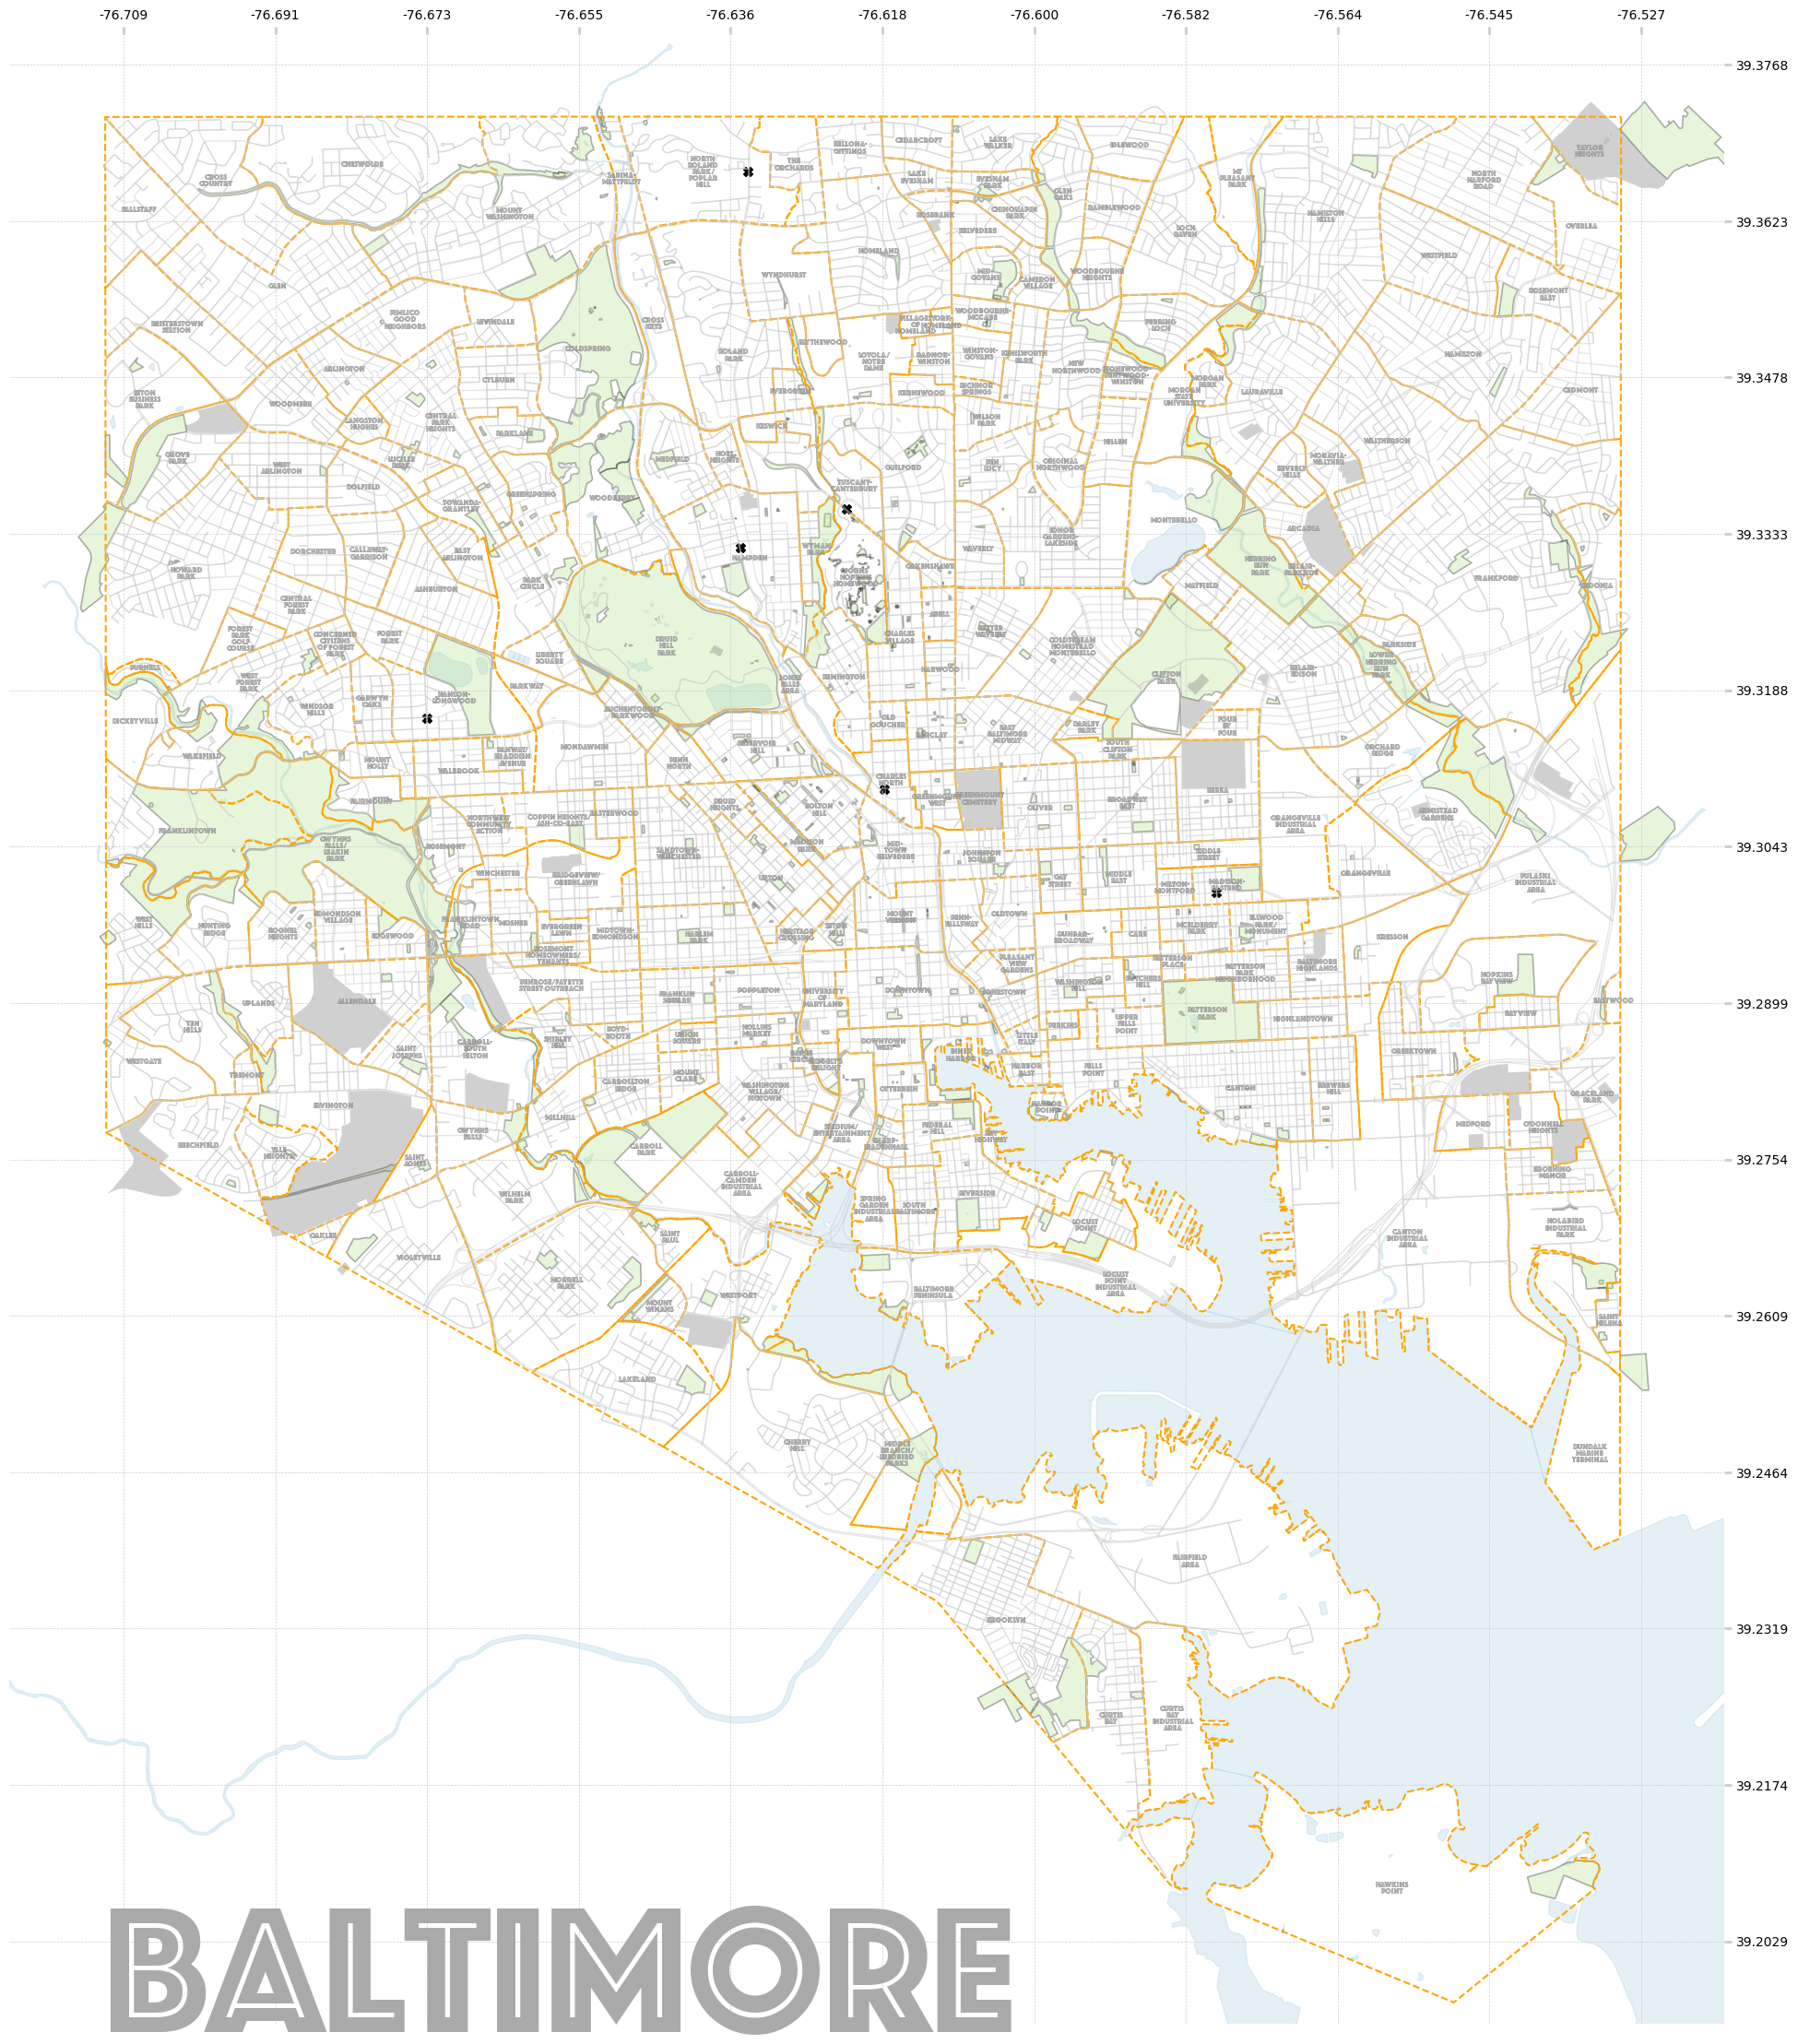

In [ ]:
## Baltimore map

from collections import namedtuple

fig, ax = plt.subplots(figsize=(24,36))

lat_lon_dist = namedtuple('lat_lon_dist', ['y', 'x'])

# one mile in latitude, longitude degrees
one_mile = lat_lon_dist(0.0144927536231884, 0.0181818181818182)

# one km in latitude, longitude degrees
one_km = lat_lon_dist(0.008983, 0.0113636)

ax.set_xlim(gdf_streets.total_bounds[0] - one_km.x, gdf_streets.total_bounds[2] + one_km.x)
ax.set_ylim(gdf_streets.total_bounds[1] - one_km.y * 1.5, gdf_streets.total_bounds[3] + one_km.y * 0.75)

# print the x and y axis as a faint grid
ax.grid(color="#cccccc", linestyle="--", linewidth=0.5)

# put the axis labels to the top and to the right
ax.xaxis.tick_top()
ax.yaxis.tick_right()

# put tick marks outside the plot
ax.tick_params(axis="both", direction="out", length=6, width=2, color="#cccccc")
# ax.tick_params(axis="both", direction="in")

# use three decimal places for the axis tick labels
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.3f"))

# draw gridlines every one mile
ax.xaxis.set_major_locator(plt.MultipleLocator(one_mile.x))
ax.yaxis.set_major_locator(plt.MultipleLocator(one_mile.y))

# turn off the axis perimeter line
for spine in ax.spines.values():
    spine.set_visible(False)

# use a dashed line for the axis grid
gdf_streets.plot(ax=ax, ec=street_color, linewidth=1, alpha=0.5)
gdf_water.plot(ax=ax, facecolor=water_blue, ec=water_blue, linewidth=1, alpha=0.3)
gdf_park.plot(ax=ax, facecolor=park_green, ec="black", linewidth=1.2, alpha=0.3)
gdf_buildings.plot(ax=ax, facecolor=cemetery_gray, linewidth=1.2, alpha=0.3)
# gdf_neighborhoods["color"] = gdf_neighborhoods.apply(lambda x: "#%06x" % random.randint(0, 0xFFFFFF), axis=1)
# gdf_neighborhoods.plot(ax=ax, facecolor=gdf_neighborhoods["color"], linestyle="--", ec="orange", linewidth=1.5, alpha=1)
gdf_neighborhoods.plot(ax=ax, facecolor="none", linestyle="--", ec="orange", linewidth=1.5, alpha=1)

# plot each point in gdf_ghost with bike-14.png as an icon
gdf_ghost.plot(ax=ax, marker="X", markersize=50, color="black", alpha=1)

font_color = "#aaaaaa"

# BALTIMORE
ax.text(
    s="Baltimore",
    x=gdf_neighborhoods.total_bounds[0],
    y=gdf_neighborhoods.total_bounds[1] - 0.003,  # + (gdf_streets.total_bounds[3] - gdf_streets.total_bounds[1]) * 0.25,
    fontsize=144,
    color=font_color,
    weight="bold",
    verticalalignment="bottom",
    horizontalalignment="left",
#    name="Avenir Next",
    name="Phosphate",
)

# # NEIGHBORHOODS 2023
# ax.text(
#     s="Neighborhoods 2023",
#     x=-76.6500,
#     y=39.2075,
#     fontsize=30,
#     color=font_color,
#     weight="bold",
#     verticalalignment="bottom",
#     horizontalalignment="left",
#     name="Avenir Next Condensed",
# )

##
## LEGEND
##
def draw_legend(x, y):
    wx = one_km.x / 3
    wy = one_km.y / 3

    # a square for the parks
    ax.add_patch(
        plt.Rectangle(
            xy=(x, y),
            width=wx,
            height=wy,
            linewidth=1,
            color=park_green,
            fill=True,
            ec="#333333",
            alpha=0.5,
        )
    )
    # and for the water
    ax.add_patch(
        plt.Rectangle(
            xy=(x, y + wy * 1.25),
            width=wx,
            height=wy,
            linewidth=1,
            color=water_blue,
            fill=True,
            ec="#333333",
            alpha=0.5,
        )
    )
    # draw a small gray square just above that
    ax.add_patch(
        plt.Rectangle(
            xy=(x, y + wy * 2.5),
            width=wx,
            height=wy,
            linewidth=1,
            color=cemetery_gray,
            fill=True,
            ec="#333333",
            alpha=0.5,
        )
    )
    # plot a single point
    ax.plot(
        x,
        y + wy * 3.75,
        marker="X",
        markersize=10,
        color="black",
        alpha=1,
    )
    # border
    ax.add_patch(
        plt.Rectangle(
            xy=(x, y + wy * 5),
            width=wx,
            height=wy/5,
            linewidth=1,
            color="orange",
            fill=True,
            # ec="#333333",
            alpha=0.5,
        )
    )
    # street
    ax.add_patch(
        plt.Rectangle(
            xy=(x, y + wy * 6.25),
            width=wx,
            height=wy/5,
            linewidth=1,
            color=street_color,
            fill=True,
            # ec="#333333",
            alpha=0.5,
        )
    )

    ax.text(
        s="Park",
        x=x + wx * 1.5,
        y=y,
        fontsize=12,
        color="black",
        verticalalignment="bottom",
        horizontalalignment="left",
        weight="light",
        name="Avenir Next Condensed",
    )

##
## SCALE
##
def draw_scale_patch(x, y):
    ax.add_patch(
        plt.Rectangle(
            xy=(x, y),
            width=one_mile.x,
            height=one_mile.y,
            linewidth=2,
            color="#aaaaaa",
            fill=False,
        )
    )
    ax.text(
        s="one\nsquare\nmile",
        x=x + one_mile.x / 2,
        y=y + one_mile.y / 2,
        fontsize=14,
        color=font_color,
        weight="bold",
        verticalalignment="center",
        horizontalalignment="center",
        name="Avenir Next",
    )

##
## COMPASS
##
def draw_compass(x, y):
    # Draw an arrow pointing north, with a fancy N above it
    ax.text(
        s="N",
        x=-76.6660,
        y=39.2480,
        fontsize=28,
        color="#666666",
        weight="bold",
        verticalalignment="bottom",
        horizontalalignment="center",
        name="Apple Chancery",
    )
    # next draw a little tiny red triangle above the N
    ax.arrow(
        x=-76.6655,
        y=39.2480,
        dx=0,
        dy=0.005,
        head_width=0.0025,
        head_length=0.0010,
        fc="orange",
        ec="orange",
        alpha=0.5,
    )

# draw_compass(-76.6660, 39.2480)
# draw_scale_patch(-76.673, 39.2319)
# draw_legend(-76.709, 39.2319)

offsets = {
    "Holabird Industrial Park": (0, +0.003),
    "Locust Point Industrial Area": (0.001, -0.0035),
    "Penrose/Fayette Street Outreach": (0, +0.0005),
    "Keswick": (-0.001, 0),
    "Loyola/Notre Dame": (+0.002, 0),
    "Irvington": (0, +0.002),
    "West Forest Park": (0, +0.001),
    "Purnell": (0, +0.0005),
}

names = {
    "Carroll - Camden Industrial Area": "Carroll-\nCamden\nIndustrial\nArea",
    "Penrose/Fayette Street Outreach": "Penrose/Fayette\nStreet Outreach",
    "Coppin Heights/Ash-Co-East": "Coppin Heights/\nAsh-Co-East",
    "Concerned Citizens of Forest Park": "Concerned\nCitizens\nof Forest\nPark",
}

def munge(name: str):
    munged_name = names.get(name, name.replace(" ", "\n").replace("/","/\n").replace("-","-\n"))
    return munged_name.upper()

# Print the name of each neighborhood on the map
for idx, row in gdf_neighborhoods.iterrows():
    x = row["geometry"].centroid.x + offsets.get(row["Name"], (0, 0))[0]
    y = row["geometry"].centroid.y + offsets.get(row["Name"], (0, 0))[1]

    ax.annotate(
        text=munge(row["Name"]),
        xy=(x, y),
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=6.5,
        color="#999999",
        weight="bold",
#        name="Avenir Next Condensed",
#        name="Academy Engraved LET",
        name="Phosphate",
    )

plt.savefig(f"{placename}.pdf", dpi=300)  # , bbox_inches='tight')
plt.show()


In [ ]:
# Print the name of each polygon on the map
for idx, row in gdf_neighborhoods.iterrows():
    ax.annotate(
        text=row["Name"],
        xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
        horizontalalignment="center",
        fontsize=4,
        color="black",
    )


In [ ]:
import prettymaps

prettymaps.preset('barcelona')


ModuleNotFoundError: No module named 'prettymaps'